<a href="https://colab.research.google.com/github/Raziel619/notebooks/blob/branch-0.8/colaboratory/cuml/umap_supervised_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UMAP Supervised Demo

[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a powerful dimensionality reduction tool, which NVIDIA recently ported to GPUs with a Python interface that matches UMAP-learn. In this notebook we will demostrate basic usage, plotting, and timing comparisons between supervised and unsupervised implementations of the CUDA (GPU) version of UMAP

## Imports and Set Up

In [0]:
# intall miniconda
# ensure Runtime is set to GPU, reset all runtimes if an error occurs
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

In [0]:
import os
import pandas as pd
import numpy as np

# libraries for scoring/clustering
from sklearn.manifold.t_sne import trustworthiness

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

In [0]:
# hide warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Sanity Checks

We are going to work with the [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) data set.  This is a dataset consisting of 70,000 28x28 grayscale images of clothing.  It should already be in the `data/fashion` folder, but let's do a sanity check!

In [0]:
#Getting data and storing in data/fashion directory
!mkdir -p data/fashion/ && wget  -O data/fashion/t10k-images-idx3-ubyte.gz https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-images-idx3-ubyte.gz?raw=true
!wget -O data/fashion/t10k-labels-idx1-ubyte.gz https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-labels-idx1-ubyte.gz?raw=true
!wget -O data/fashion/train-images-idx3-ubyte.gz https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz?raw=true
!wget -O data/fashion/train-labels-idx1-ubyte.gz https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-labels-idx1-ubyte.gz?raw=true


In [0]:
!ls data/fashion
if not os.path.exists('data/fashion'):
    print("error, data is missing!")

Now let's make sure we have our RAPIDS compliant GPU.  It must be Pascal or higher!  You can also use this to define which GPU RAPIDS should use (advanced feature not covered here)

In [0]:
!nvidia-smi

## Helper Functions

In [0]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)    
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
    print(labels_path)
    print(images_path)
    
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Training

In [192]:
train, train_labels = load_mnist('data/fashion/', kind='train')
test, test_labels = load_mnist('data/fashion/', kind='t10k')
data = (np.array(np.vstack([train, test]), dtype=np.float64) [:60000]/ 255.0).astype(np.float32)
target = np.array(np.hstack([train_labels, test_labels]))[:60000].astype(np.float32)

data/fashion/train-labels-idx1-ubyte.gz
data/fashion/train-images-idx3-ubyte.gz
data/fashion/t10k-labels-idx1-ubyte.gz
data/fashion/t10k-images-idx3-ubyte.gz


There are 60000 training images and 10000 test images

In [193]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

In [194]:
train[0].shape

(784,)

As mentioned previously, each row in the train matrix is an image

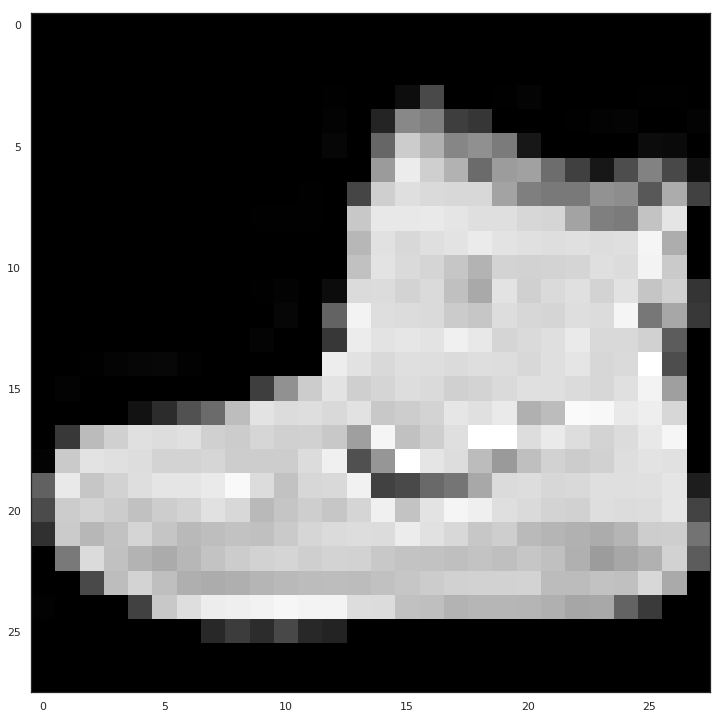

In [195]:
# display a Nike? sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

There is cost with moving data between host memory and device memory (GPU memory) and we will include that core when comparing speeds

In [196]:
%%time
record_data = (('fea%d'%i, data[:,i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame(record_data)

label_data = [('fea%0', target)]

target_gdf = cudf.DataFrame(label_data)

CPU times: user 1.86 s, sys: 666 ms, total: 2.53 s
Wall time: 2.63 s


In [0]:
import time

`gdf` is a GPU backed dataframe -- all the data is stored in the device memory of the GPU.  With the data converted, we can apply the `cumlUMAP` the same inputs as we do for the standard UMAP.

For datasets that provide a set of labels, we can pass those labels into the `fit()` and `fit_transform()` functions to have UMAP use them for better cluster separation. Supervised training can even be used with an incomplete set of labels by setting the unknown labels to -1". It is important that the labels array be the same size as the number of samples being used to train.

In [198]:
start = time.time()
g_embedding_supervised = cumlUMAP(verbose = False, n_neighbors=5, init="spectral", target_metric = "categorical").fit_transform(gdf, target_gdf)
print("Took %f sec." % (time.time() - start))

Took 6.143622 sec.


In [199]:
start = time.time()
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)
print("Took %f sec." % (time.time() - start))

Took 4.931214 sec.


## Visualization

OK, now let's plot the output of the embeddings so that we can see the seperation of the neighborhoods.  Let's start by creating the classes.

In [0]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

Just as the original author of UMAP, Leland McInnes, states in the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/supervised.html), we can plot the results and show the separation between the various classes defined above.

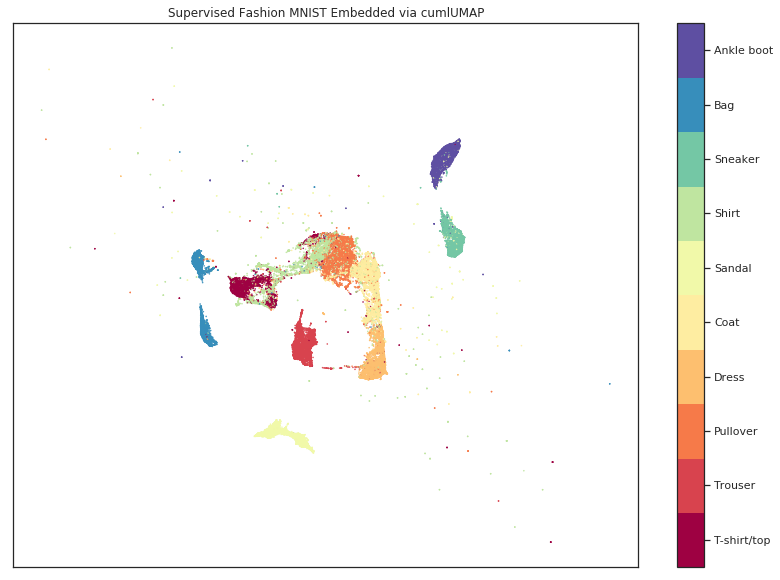

In [201]:
g_embedding_supervised_numpy = g_embedding_supervised.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding_supervised_numpy[:,1], g_embedding_supervised_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Supervised Fashion MNIST Embedded via cumlUMAP');

## Comparison of Implementations

And side-by-side we can see the effects of supervised training.  Notice how providing the labels enables the resulting model to better separation of sneakers, ankle books, and sandals while also providing a much more distinct separation of shirts, t-shirts, pullovers, and coats. 

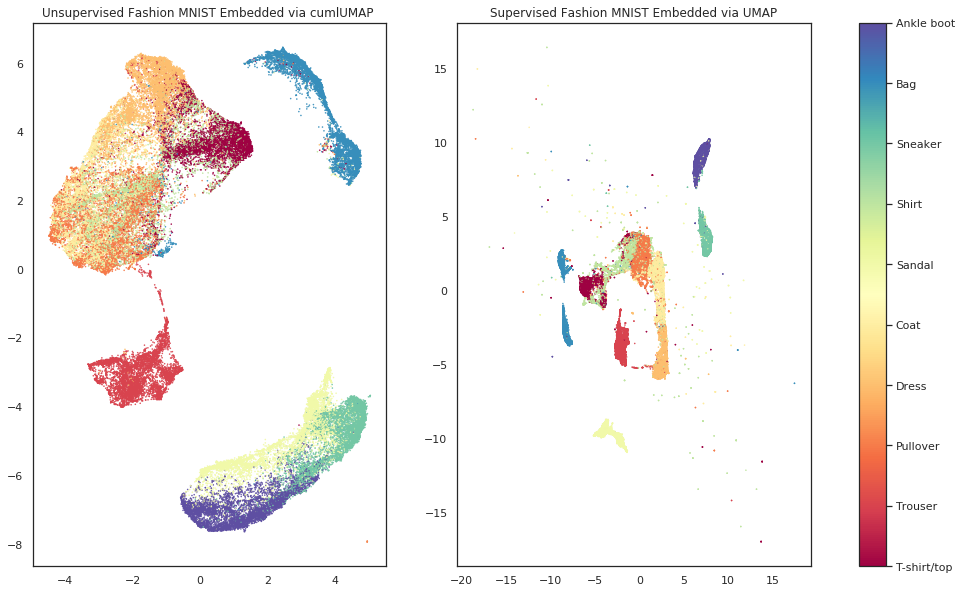

In [202]:
g_embedding_numpy = g_embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
im = ax[1].scatter(g_embedding_supervised_numpy[:,1], g_embedding_supervised_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
ax[0].set_title('Unsupervised Fashion MNIST Embedded via cumlUMAP ');
ax[1].set_title('Supervised Fashion MNIST Embedded via UMAP');

fig.subplots_adjust(right=0.8)
cax,kw = mpl.colorbar.make_axes([a for a in ax.flat])
cbar = plt.colorbar(im, cax=cax, **kw)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

Additionally, we can also quanititaviely compare the perfomance of `cumlUMAP` (GPU UMAP) to the reference/original implementation (CPU UMAP) using the [trustworthiness score](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/t_sne.py#L395).  From the docstring:

> Trustworthiness expresses to what extent the local structure is retained.  The trustworthiness is within [0, 1].


Like `t-SNE`, UMAP tries to capture both global and local structure and thus, we can apply the `trustworthiness` of the `embedding/g_embedding` data against the original input.  With a higher score we are demonstrating that the algorithm does a better and better job of local structure retention.  As [Corey Nolet](https://github.com/cjnolet) notes:
> Algorithms like UMAP aim to preserve local neighborhood structure and so measuring this property (trustworthiness) measures the algorithm's performance.

Scoring ~97% shows the GPU implementation is comparable to the original CPU implementation and the training time was ~9.5X faster